In [2]:
import numpy as np 
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm

In [7]:
# utility functions

def one_hot_encoded(y, num_class):
    n = y.shape[0]
    onehot = np.zeros((n, num_class), dtype="int32")
    for i in range(n):
        idx = y[i]
        onehot[i][idx] = 1
    return onehot


def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)  # both are not one hot encoded


def softmax(x):
    max_x = np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x-max_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    # YOUR CODE HERE
    
# l2 regularization
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss


# l2 regularization grad
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads


In [8]:
softmax([[1,2,1]])

array([[0.21194156, 0.57611688, 0.21194156]])

In [11]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [12]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return np.maximum(X,0)
        # YOUR CODE HERE
    
    def backward(self, dout, mode):
        self.gradInput = dout.copy()
        self.gradInput[self.X<=0] = 0
        return self.gradInput, []
        # YOUR CODE HERE


In [13]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = ReLU()
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 12))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [16]:
class Linear():

    def __init__(self, in_size, out_size):

        # Xavier init
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size/ 2.)
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return X.dot(self.W) + self.b
        # YOUR CODE HERE
        pass
    
    def backward(self, dout, mode):
        self.gradW = self.X.T.dot(dout)
        self.gradInput = dout.dot(self.W.T)
        self.gradB = dout.sum(axis=0)
        return self.gradInput, [self.gradW, self.gradB]
        # YOUR CODE HERE
        pass

In [17]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = Linear(12, 5)
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 5))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[-1.0773238   1.45328929 -0.94217697  0.18629766 -0.39587126  0.27521949
   0.3379231  -0.54677066 -1.32830072 -0.64419137 -0.21888084  0.41351198]
 [-1.0773238   1.45328929 -0.94217697  0.18629766 -0.39587126  0.27521949
   0.3379231  -0.54677066 -1.32830072 -0.64419137 -0.21888084  0.41351198]
 [-1.0773238   1.45328929 -0.94217697  0.18629766 -0.39587126  0.27521949
   0.3379231  -0.54677066 -1.32830072 -0.64419137 -0.21888084  0.41351198]
 [-1.0773238   1.45328929 -0.94217697  0.18629766 -0.39587126  0.27521949
   0.3379231  -0.54677066 -1.32830072 -0.64419137 -0.21888084  0.41351198]
 [-1.0773238   1.45328929 -0.94217697  0.18629766 -0.39587126  0.27521949
   0.3379231  -0.54677066 -1.32830072 -0.64419137 -0.21888084  0.41351198]
 [-1.0773238   1.45328929 -0.94217697  0.18629766 -0.39587126  0.27521949
   0.3379231  -0.54677066 -1.32830072 -0.64419137 -0.21888084  0.41351198]
 [-1.0773238   1.45328929 -0.94217697  0.18629766 -0.39587126  0.27521949
   0.3379231  -0.54677066 -1.328

In [25]:
class CrossEntropyLoss(object):

    def forward(self, X, y):
        self.m = y.shape[0] # self.m ==X.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = np.sum(cross_entropy) / self.m
        return loss
        # YOUR CODE HERE
        pass
    
    def backward(self, X, y):
        dx = self.p.copy()
        dx[range(self.m), y] -=1
        dx /= self.m
        return dx
        # YOUR CODE HERE
        pass

## NN implementation

In [26]:
class NN:

    def __init__(self, loss_func=CrossEntropyLoss(), mode = 'train'):
    
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self,layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)
        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        dout = self.loss_func.backward(out,y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)


    def dispGradParam():
        print(self.grads)
    

    def clear_grad_param(self):
        self.grads = []

In [27]:
# SGD with momentum
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    X, y = shuffle(X, y)

    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, ...]
        y_batch = y[i:i + minibatch_size, ...]

        minibatches.append((X_batch, y_batch))
    return minibatches


In [28]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
                 verbose=True, X_val=None, y_val=None, nesterov=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0 
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        if verbose:
            print("Epoch {0}".format(i + 1))

        # iterate over mini batches
        for X_mini, y_mini in tqdm(minibatches):

            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in tqdm(minibatches_val):
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)


        # accuracy of model at end of epoch after all mini batch updates   

        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))


            # early stopping with patience = 5 on val loss

            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)    


            print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(
                mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net


In [39]:

# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
])

y_train = np.array([0, 1, 0, 1])
X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
model.add_layer(Linear(X_train.shape[1], 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 2))
# YOUR CODE HERE

model = train(model, X_train , y_train, minibatch_size=4, epoch=100,
           learning_rate=0.1, X_val=X_val, y_val=y_val)




(4, 4)
(4, 4)
Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]


Loss = 0.7259230183107142 | Training Accuracy = 0.5 | Val Loss = 0.6812951211473081 | Val Accuracy = 0.5
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 886.56it/s]


Loss = 0.6812951211473081 | Training Accuracy = 0.5 | Val Loss = 0.6748872105230693 | Val Accuracy = 0.5
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.71it/s]


Loss = 0.6748872105230693 | Training Accuracy = 0.5 | Val Loss = 0.6687261978258063 | Val Accuracy = 0.5
Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


Loss = 0.6687261978258063 | Training Accuracy = 0.5 | Val Loss = 0.6626262761855299 | Val Accuracy = 0.5
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 586.37it/s]


Loss = 0.6626262761855299 | Training Accuracy = 0.5 | Val Loss = 0.6564572579434224 | Val Accuracy = 0.5
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 984.81it/s]


Loss = 0.6564572579434224 | Training Accuracy = 0.5 | Val Loss = 0.6503897872513242 | Val Accuracy = 0.5
Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1030.29it/s]


Loss = 0.6503897872513242 | Training Accuracy = 0.5 | Val Loss = 0.6443689690372335 | Val Accuracy = 0.5
Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.6443689690372335 | Training Accuracy = 0.5 | Val Loss = 0.6383839047734338 | Val Accuracy = 0.5
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.19it/s]


Loss = 0.6383839047734338 | Training Accuracy = 0.5 | Val Loss = 0.6324298729471043 | Val Accuracy = 0.5
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.95it/s]


Loss = 0.6324298729471043 | Training Accuracy = 0.5 | Val Loss = 0.6265026716166114 | Val Accuracy = 0.5
Epoch 11


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.6265026716166114 | Training Accuracy = 0.5 | Val Loss = 0.6205984252483526 | Val Accuracy = 0.5
Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 712.11it/s]


Loss = 0.6205984252483526 | Training Accuracy = 0.5 | Val Loss = 0.6147135403404355 | Val Accuracy = 0.5
Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.71it/s]


Loss = 0.6147135403404355 | Training Accuracy = 0.5 | Val Loss = 0.6088446741882488 | Val Accuracy = 0.5
Epoch 14


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.6088446741882488 | Training Accuracy = 0.5 | Val Loss = 0.6029887106883434 | Val Accuracy = 0.5
Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.59it/s]


Loss = 0.6029887106883434 | Training Accuracy = 0.5 | Val Loss = 0.5971427412131561 | Val Accuracy = 0.5
Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1010.92it/s]


Loss = 0.5971427412131561 | Training Accuracy = 0.5 | Val Loss = 0.5913040492292851 | Val Accuracy = 0.5
Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1265.25it/s]


Loss = 0.5913040492292851 | Training Accuracy = 0.5 | Val Loss = 0.5854700977483073 | Val Accuracy = 0.5
Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 976.56it/s]


Loss = 0.5854700977483073 | Training Accuracy = 0.5 | Val Loss = 0.5796385189850496 | Val Accuracy = 0.5
Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


Loss = 0.5796385189850496 | Training Accuracy = 0.5 | Val Loss = 0.5738071057906505 | Val Accuracy = 0.5
Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.83it/s]


Loss = 0.5738071057906505 | Training Accuracy = 0.5 | Val Loss = 0.5679738045566328 | Val Accuracy = 0.5
Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


Loss = 0.5679738045566328 | Training Accuracy = 0.5 | Val Loss = 0.5621367093725316 | Val Accuracy = 0.5
Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1005.83it/s]


Loss = 0.5621367093725316 | Training Accuracy = 0.5 | Val Loss = 0.5562940572774835 | Val Accuracy = 0.5
Epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.16it/s]


Loss = 0.5562940572774835 | Training Accuracy = 0.5 | Val Loss = 0.5504442244848848 | Val Accuracy = 0.5
Epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.02it/s]


Loss = 0.5504442244848848 | Training Accuracy = 0.5 | Val Loss = 0.5445857234850083 | Val Accuracy = 0.5
Epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]


Loss = 0.5445857234850083 | Training Accuracy = 0.5 | Val Loss = 0.5387172009474269 | Val Accuracy = 0.5
Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1696.72it/s]


Loss = 0.5387172009474269 | Training Accuracy = 1.0 | Val Loss = 0.5328374363560119 | Val Accuracy = 1.0
Epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.31it/s]


Loss = 0.5328374363560119 | Training Accuracy = 1.0 | Val Loss = 0.5269453413159907 | Val Accuracy = 1.0
Epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


Loss = 0.5269453413159907 | Training Accuracy = 1.0 | Val Loss = 0.5210399594763336 | Val Accuracy = 1.0
Epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 846.48it/s]


Loss = 0.5210399594763336 | Training Accuracy = 1.0 | Val Loss = 0.5151204670124182 | Val Accuracy = 1.0
Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


Loss = 0.5151204670124182 | Training Accuracy = 1.0 | Val Loss = 0.5091861736140925 | Val Accuracy = 1.0
Epoch 31


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.5091861736140925 | Training Accuracy = 1.0 | Val Loss = 0.5032365239233314 | Val Accuracy = 1.0
Epoch 32


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.5032365239233314 | Training Accuracy = 1.0 | Val Loss = 0.4972710993639266 | Val Accuracy = 1.0
Epoch 33


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.4972710993639266 | Training Accuracy = 1.0 | Val Loss = 0.49128962030330653 | Val Accuracy = 1.0
Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1012.14it/s]


Loss = 0.49128962030330653 | Training Accuracy = 1.0 | Val Loss = 0.48529194848380475 | Val Accuracy = 1.0
Epoch 35


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 647.47it/s]


Loss = 0.48529194848380475 | Training Accuracy = 1.0 | Val Loss = 0.4792780896576152 | Val Accuracy = 1.0
Epoch 36


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 441.13it/s]


Loss = 0.4792780896576152 | Training Accuracy = 1.0 | Val Loss = 0.4732381765822387 | Val Accuracy = 1.0
Epoch 37


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]


Loss = 0.4732381765822387 | Training Accuracy = 1.0 | Val Loss = 0.4662084342502675 | Val Accuracy = 1.0
Epoch 38


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 555.83it/s]


Loss = 0.4662084342502675 | Training Accuracy = 1.0 | Val Loss = 0.4599555998399608 | Val Accuracy = 1.0
Epoch 39


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 560.36it/s]


Loss = 0.4599555998399608 | Training Accuracy = 1.0 | Val Loss = 0.4537719038600215 | Val Accuracy = 1.0
Epoch 40


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1122.67it/s]


Loss = 0.4537719038600215 | Training Accuracy = 1.0 | Val Loss = 0.4475908351515572 | Val Accuracy = 1.0
Epoch 41


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]


Loss = 0.4475908351515572 | Training Accuracy = 1.0 | Val Loss = 0.44140806235042507 | Val Accuracy = 1.0
Epoch 42


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1465.00it/s]


Loss = 0.44140806235042507 | Training Accuracy = 1.0 | Val Loss = 0.43515759604876747 | Val Accuracy = 1.0
Epoch 43


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 983.19it/s]


Loss = 0.43515759604876747 | Training Accuracy = 1.0 | Val Loss = 0.42892499279516466 | Val Accuracy = 1.0
Epoch 44


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 237.31it/s]


Loss = 0.42892499279516466 | Training Accuracy = 1.0 | Val Loss = 0.42270004610081335 | Val Accuracy = 1.0
Epoch 45


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.42270004610081335 | Training Accuracy = 1.0 | Val Loss = 0.4165088618543656 | Val Accuracy = 1.0
Epoch 46


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1044.14it/s]


Loss = 0.4165088618543656 | Training Accuracy = 1.0 | Val Loss = 0.41032782586222394 | Val Accuracy = 1.0
Epoch 47


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 462.90it/s]


Loss = 0.41032782586222394 | Training Accuracy = 1.0 | Val Loss = 0.40407697292161693 | Val Accuracy = 1.0
Epoch 48


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


Loss = 0.40407697292161693 | Training Accuracy = 1.0 | Val Loss = 0.39670611750452767 | Val Accuracy = 1.0
Epoch 49


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


Loss = 0.39670611750452767 | Training Accuracy = 1.0 | Val Loss = 0.38995929649230016 | Val Accuracy = 1.0
Epoch 50


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.89it/s]


Loss = 0.38995929649230016 | Training Accuracy = 1.0 | Val Loss = 0.3836645175444587 | Val Accuracy = 1.0
Epoch 51


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1475.31it/s]


Loss = 0.3836645175444587 | Training Accuracy = 1.0 | Val Loss = 0.3773848515361562 | Val Accuracy = 1.0
Epoch 52


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.95it/s]


Loss = 0.3773848515361562 | Training Accuracy = 1.0 | Val Loss = 0.3711185194874995 | Val Accuracy = 1.0
Epoch 53


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


Loss = 0.3711185194874995 | Training Accuracy = 1.0 | Val Loss = 0.364867701941529 | Val Accuracy = 1.0
Epoch 54


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2759.41it/s]


Loss = 0.364867701941529 | Training Accuracy = 1.0 | Val Loss = 0.358635338227361 | Val Accuracy = 1.0
Epoch 55


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]


Loss = 0.358635338227361 | Training Accuracy = 1.0 | Val Loss = 0.3524247039518271 | Val Accuracy = 1.0
Epoch 56


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1035.12it/s]


Loss = 0.3524247039518271 | Training Accuracy = 1.0 | Val Loss = 0.34623918210867316 | Val Accuracy = 1.0
Epoch 57


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.90it/s]


Loss = 0.34623918210867316 | Training Accuracy = 1.0 | Val Loss = 0.34008228114190703 | Val Accuracy = 1.0
Epoch 58


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.91it/s]


Loss = 0.34008228114190703 | Training Accuracy = 1.0 | Val Loss = 0.33395757582134683 | Val Accuracy = 1.0
Epoch 59


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1804.00it/s]


Loss = 0.33395757582134683 | Training Accuracy = 1.0 | Val Loss = 0.3279308298341623 | Val Accuracy = 1.0
Epoch 60


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


Loss = 0.3279308298341623 | Training Accuracy = 1.0 | Val Loss = 0.32191307660077473 | Val Accuracy = 1.0
Epoch 61


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.32191307660077473 | Training Accuracy = 1.0 | Val Loss = 0.3158917574096848 | Val Accuracy = 1.0
Epoch 62


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.88it/s]


Loss = 0.3158917574096848 | Training Accuracy = 1.0 | Val Loss = 0.30992660233862157 | Val Accuracy = 1.0
Epoch 63


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


Loss = 0.30992660233862157 | Training Accuracy = 1.0 | Val Loss = 0.304063671192797 | Val Accuracy = 1.0
Epoch 64


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.17it/s]


Loss = 0.304063671192797 | Training Accuracy = 1.0 | Val Loss = 0.29877708683252746 | Val Accuracy = 1.0
Epoch 65


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1066.71it/s]


Loss = 0.29877708683252746 | Training Accuracy = 1.0 | Val Loss = 0.29296333801863994 | Val Accuracy = 1.0
Epoch 66


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 977.01it/s]


Loss = 0.29296333801863994 | Training Accuracy = 1.0 | Val Loss = 0.28737750453119437 | Val Accuracy = 1.0
Epoch 67


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


Loss = 0.28737750453119437 | Training Accuracy = 1.0 | Val Loss = 0.28160087887522856 | Val Accuracy = 1.0
Epoch 68


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.39it/s]


Loss = 0.28160087887522856 | Training Accuracy = 1.0 | Val Loss = 0.2758277994126313 | Val Accuracy = 1.0
Epoch 69


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]


Loss = 0.2758277994126313 | Training Accuracy = 1.0 | Val Loss = 0.2700483524672078 | Val Accuracy = 1.0
Epoch 70


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


Loss = 0.2700483524672078 | Training Accuracy = 1.0 | Val Loss = 0.26453646903203265 | Val Accuracy = 1.0
Epoch 71


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 462.69it/s]


Loss = 0.26453646903203265 | Training Accuracy = 1.0 | Val Loss = 0.2590993544467836 | Val Accuracy = 1.0
Epoch 72


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 870.73it/s]


Loss = 0.2590993544467836 | Training Accuracy = 1.0 | Val Loss = 0.25373527868533485 | Val Accuracy = 1.0
Epoch 73


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.20it/s]


Loss = 0.25373527868533485 | Training Accuracy = 1.0 | Val Loss = 0.24854092763045027 | Val Accuracy = 1.0
Epoch 74


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]


Loss = 0.24854092763045027 | Training Accuracy = 1.0 | Val Loss = 0.24386238302179408 | Val Accuracy = 1.0
Epoch 75


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 732.89it/s]


Loss = 0.24386238302179408 | Training Accuracy = 1.0 | Val Loss = 0.23921514637509694 | Val Accuracy = 1.0
Epoch 76


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


Loss = 0.23921514637509694 | Training Accuracy = 1.0 | Val Loss = 0.23490637116522406 | Val Accuracy = 1.0
Epoch 77


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]


Loss = 0.23490637116522406 | Training Accuracy = 1.0 | Val Loss = 0.2297474867583177 | Val Accuracy = 1.0
Epoch 78


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.91it/s]


Loss = 0.2297474867583177 | Training Accuracy = 1.0 | Val Loss = 0.22529507551193378 | Val Accuracy = 1.0
Epoch 79


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.66it/s]


Loss = 0.22529507551193378 | Training Accuracy = 1.0 | Val Loss = 0.22041607187016315 | Val Accuracy = 1.0
Epoch 80


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 954.55it/s]


Loss = 0.22041607187016315 | Training Accuracy = 1.0 | Val Loss = 0.21845680830053915 | Val Accuracy = 1.0
Epoch 81


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1098.85it/s]


Loss = 0.21845680830053915 | Training Accuracy = 1.0 | Val Loss = 0.21432272691911777 | Val Accuracy = 1.0
Epoch 82


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 968.89it/s]


Loss = 0.21432272691911777 | Training Accuracy = 1.0 | Val Loss = 0.21439113193785003 | Val Accuracy = 1.0
Epoch 83


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]


Loss = 0.21439113193785003 | Training Accuracy = 1.0 | Val Loss = 0.20853578938859751 | Val Accuracy = 1.0
Epoch 84


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1102.60it/s]


Loss = 0.20853578938859751 | Training Accuracy = 1.0 | Val Loss = 0.21178175951767855 | Val Accuracy = 1.0
Epoch 85


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


Loss = 0.21178175951767855 | Training Accuracy = 1.0 | Val Loss = 0.2031265355151053 | Val Accuracy = 1.0
Epoch 86


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 688.04it/s]


Loss = 0.2031265355151053 | Training Accuracy = 1.0 | Val Loss = 0.20881988134588397 | Val Accuracy = 1.0
Epoch 87


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1123.27it/s]


Loss = 0.20881988134588397 | Training Accuracy = 1.0 | Val Loss = 0.1976245056681387 | Val Accuracy = 1.0
Epoch 88


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1266.40it/s]


Loss = 0.1976245056681387 | Training Accuracy = 1.0 | Val Loss = 0.20294163619923727 | Val Accuracy = 1.0
Epoch 89


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


Loss = 0.20294163619923727 | Training Accuracy = 1.0 | Val Loss = 0.19043877212972815 | Val Accuracy = 1.0
Epoch 90


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.91it/s]


Loss = 0.19043877212972815 | Training Accuracy = 1.0 | Val Loss = 0.19734058230420098 | Val Accuracy = 1.0
Epoch 91


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 971.13it/s]


Loss = 0.19734058230420098 | Training Accuracy = 1.0 | Val Loss = 0.18276950507155837 | Val Accuracy = 1.0
Epoch 92


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 983.65it/s]


Loss = 0.18276950507155837 | Training Accuracy = 1.0 | Val Loss = 0.1884964322728557 | Val Accuracy = 1.0
Epoch 93


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 514.70it/s]


Loss = 0.1884964322728557 | Training Accuracy = 1.0 | Val Loss = 0.1748573860921025 | Val Accuracy = 1.0
Epoch 94


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


Loss = 0.1748573860921025 | Training Accuracy = 1.0 | Val Loss = 0.17912960630184585 | Val Accuracy = 1.0
Epoch 95


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 652.51it/s]


Loss = 0.17912960630184585 | Training Accuracy = 1.0 | Val Loss = 0.16660409277777677 | Val Accuracy = 1.0
Epoch 96


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


Loss = 0.16660409277777677 | Training Accuracy = 1.0 | Val Loss = 0.16819512970159028 | Val Accuracy = 1.0
Epoch 97


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Loss = 0.16819512970159028 | Training Accuracy = 1.0 | Val Loss = 0.15860346969784667 | Val Accuracy = 1.0
Epoch 98


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]


Loss = 0.15860346969784667 | Training Accuracy = 1.0 | Val Loss = 0.15995775778406005 | Val Accuracy = 1.0
Epoch 99


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1019.77it/s]


Loss = 0.15995775778406005 | Training Accuracy = 1.0 | Val Loss = 0.1514250935296741 | Val Accuracy = 1.0
Epoch 100


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


Loss = 0.1514250935296741 | Training Accuracy = 1.0 | Val Loss = 0.15157427642784177 | Val Accuracy = 1.0


## Mnist training

In [40]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [41]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [42]:
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)


In [51]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


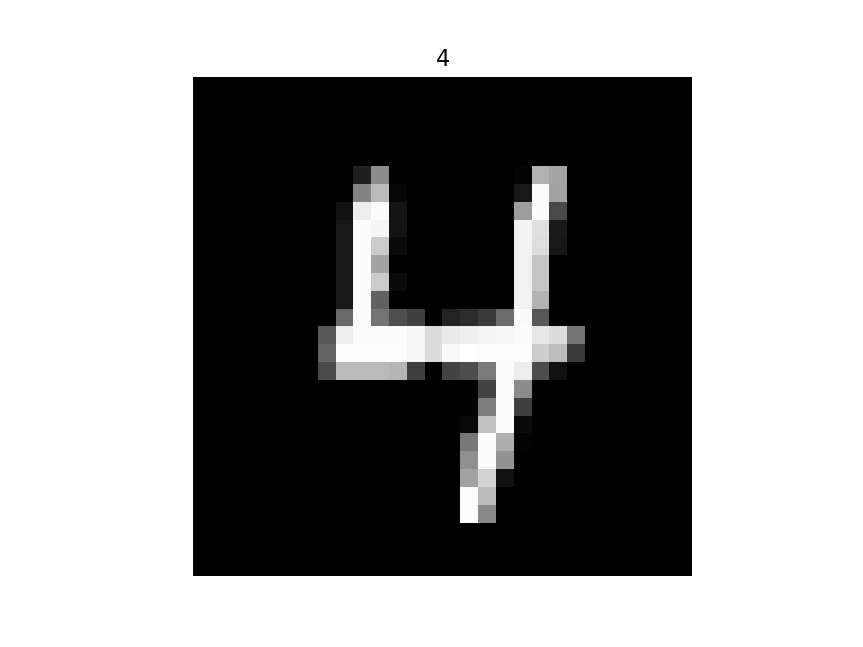

In [44]:
# visualize data

def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

vis_idx = 0
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

In [49]:
print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
# YOUR CODE HERE
model.add_layer(Linear(X_train.shape[1], 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 10))

model = train(model, X_train , y_train, minibatch_size=128, epoch=10,
           learning_rate=0.001, X_val=X_val, y_val=y_val)




(52500, 784)
(17500, 784)
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 375.03it/s]


Loss = 1.102015722180171 | Training Accuracy = 0.9079238095238096 | Val Loss = 0.40602196613399105 | Val Accuracy = 0.8955428571428572
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 340.04it/s]


Loss = 0.3680606566515522 | Training Accuracy = 0.9316952380952381 | Val Loss = 0.3188283308961983 | Val Accuracy = 0.9196571428571428
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 363.91it/s]


Loss = 0.3026035688541191 | Training Accuracy = 0.9419428571428572 | Val Loss = 0.31096453629399184 | Val Accuracy = 0.9272
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 369.39it/s]


Loss = 0.26431005807317526 | Training Accuracy = 0.951047619047619 | Val Loss = 0.24123536933861178 | Val Accuracy = 0.9341142857142857
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 368.93it/s]


Loss = 0.24118805044408556 | Training Accuracy = 0.9572761904761905 | Val Loss = 0.2477595497567623 | Val Accuracy = 0.9386857142857142
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 362.44it/s]


Loss = 0.22460268849655565 | Training Accuracy = 0.9614857142857143 | Val Loss = 0.22045407407205153 | Val Accuracy = 0.9421142857142857
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 360.65it/s]


Loss = 0.2111205341291449 | Training Accuracy = 0.9634285714285714 | Val Loss = 0.2110463212123259 | Val Accuracy = 0.9426857142857142
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 365.32it/s]


Loss = 0.19950181620791077 | Training Accuracy = 0.9663619047619048 | Val Loss = 0.1892464192975716 | Val Accuracy = 0.9444
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 364.81it/s]


Loss = 0.1912396877968528 | Training Accuracy = 0.9678285714285715 | Val Loss = 0.1855178910606847 | Val Accuracy = 0.9467428571428571
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 364.36it/s]


Loss = 0.18385726286153112 | Training Accuracy = 0.9709904761904762 | Val Loss = 0.1823496204981157 | Val Accuracy = 0.9481714285714286


<IPython.core.display.Javascript object>


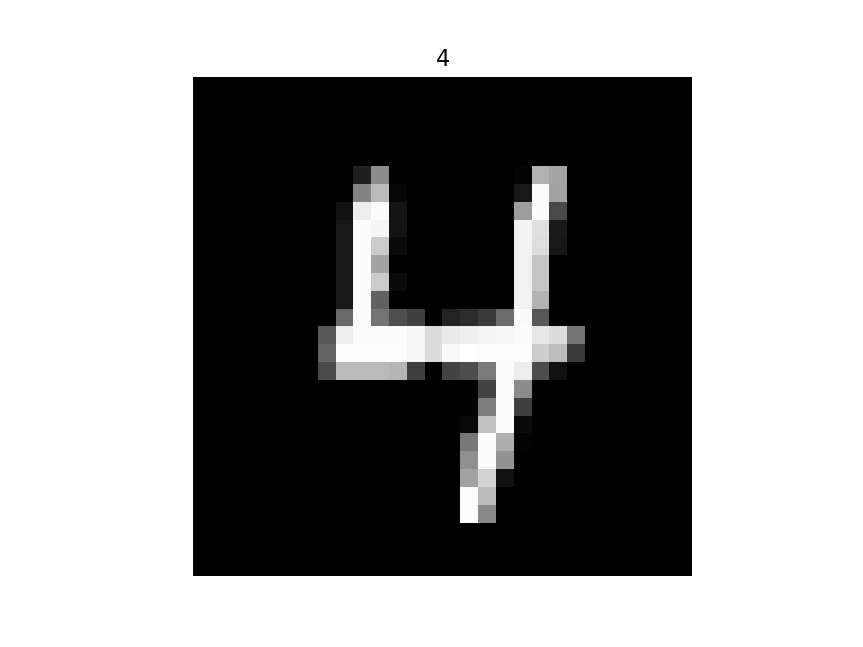

In [52]:
# visualize prediction 

vis_idx = 1
pred = model.predict(X_val[vis_idx])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])


# TODO:
1) Add computational graph instead of list, model saving/loading, more optimizers, shedulers loss functions, operations, gpu support, utility tools ...

... Or simply use Pytorch/TF/whatever